# Introdução ao Projeto de Modelagem Preditiva do IBOVESPA

Fomos escalados para integrar o time de investimentos com o objetivo de desenvolver um modelo preditivo capaz de prever o fechamento diário do índice IBOVESPA, principal indicador do desempenho das ações negociadas na B3 (Bolsa de Valores do Brasil). A precisão dessas previsões é fundamental para informar nossas estratégias de investimento e tomada de decisão. Este projeto envolverá uma abordagem completa, desde a coleta dos dados até a entrega do modelo final, acompanhado de uma justificativa clara para a técnica escolhida.

## Importações e instalações de bibliotecas necessárias

In [293]:
!pip install statsforecast

In [294]:
!pip install pmdarima


In [295]:
!pip install statsmodels

In [296]:
!pip install prophet

In [297]:
!pip install xgboost

In [298]:
!pip install seaborn

In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error,make_scorer
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
import warnings
warnings.filterwarnings('ignore')

## Leitura, exploração e adequação do Dataset:
Fonte: https://br.investing.com/indices/bovespa-historical-data

Período: 21-07-2020 a 19-07-2024.



In [300]:
df = pd.read_csv('ibovespa_2020_2024.csv', parse_dates=[0], dtype={'Último': str,'Abertura':str})
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-07-19,127.616,127.652,128.360,127.413,"7,62M","-0,03%"
1,2024-07-18,127.652,129.450,129.454,127.523,"7,59M","-1,39%"
2,2024-07-17,129.450,129.112,129.658,128.741,"6,67M","0,26%"
3,2024-07-16,129.110,129.322,129.521,128.761,"6,82M","-0,16%"
4,2024-07-15,129.321,128.898,129.485,128.723,"5,83M","0,33%"


In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      996 non-null    datetime64[ns]
 1   Último    996 non-null    object        
 2   Abertura  996 non-null    object        
 3   Máxima    996 non-null    float64       
 4   Mínima    996 non-null    float64       
 5   Vol.      996 non-null    object        
 6   Var%      996 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 54.6+ KB


In [302]:
df_novo = df[['Data', 'Último','Abertura']]
df_novo = df_novo.rename(columns={'Último': 'y', 'Data': 'ds','Abertura':'abertura'})
df_novo = df_novo.set_index('ds').sort_index()
df_novo.head()

,y,abertura
ds,,
2020-07-21,104.310,104.426
2020-07-22,104.290,104.312
2020-07-23,102.293,104.291
2020-07-24,102.382,102.292
2020-07-27,104.477,102.381


In [303]:
df_novo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 996 entries, 2020-07-21 to 2024-07-19
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   y         996 non-null    object
 1   abertura  996 non-null    object
dtypes: object(2)
memory usage: 23.3+ KB


In [304]:
df_novo['y'] = df_novo['y'].str.replace('.', '').astype(int)
df_novo['abertura'] = df_novo['abertura'].str.replace('.', '').astype(int)

In [305]:
df_novo.tail()

,y,abertura
ds,,
2024-07-15,129321,128898
2024-07-16,129110,129322
2024-07-17,129450,129112
2024-07-18,127652,129450
2024-07-19,127616,127652


In [306]:
df_novo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 996 entries, 2020-07-21 to 2024-07-19
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   y         996 non-null    int64
 1   abertura  996 non-null    int64
dtypes: int64(2)
memory usage: 23.3 KB


In [307]:
df_novo.describe()

,y,abertura
count,996.000000,996.000000
mean,114310.898594,114288.108434
std,9268.946347,9264.290646
min,93580.000000,93586.000000
25%,107237.000000,107166.250000
50%,114062.000000,114038.500000
75%,120702.250000,120701.000000
max,134194.000000,134194.000000


In [308]:
df_novo.isnull().sum()

y           0
abertura    0
dtype: int64

## Análise Visual do Dataset

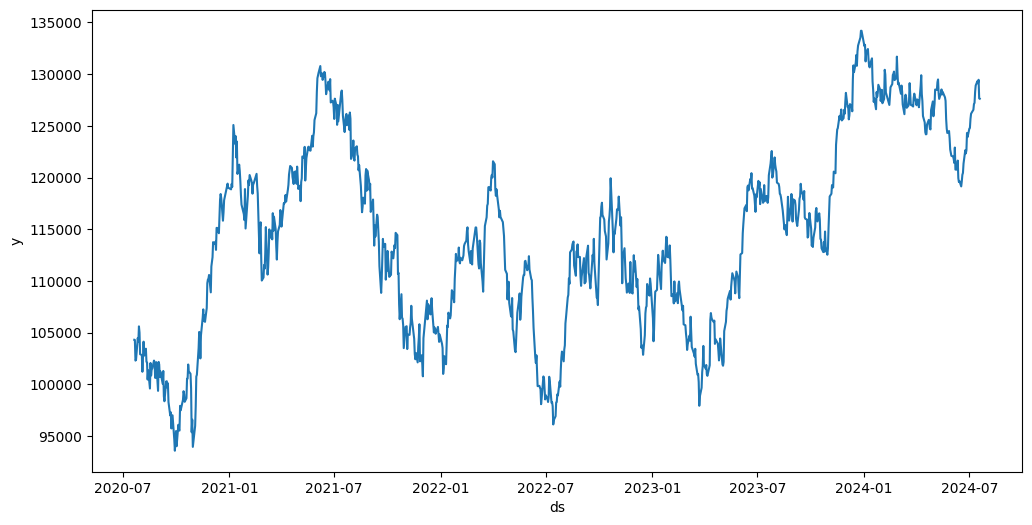

In [309]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='ds', y='y', data=df_novo)
plt.show()

In [310]:
#Preenchendo os finais de semana com valor do dia anterior
df_diario = df_novo.asfreq('D')
df_diario.fillna(method='ffill', inplace=True)

In [311]:
df_diario = df_diario.astype(int)

In [312]:
df_diario.head()

,y,abertura
ds,,
2020-07-21,104310,104426
2020-07-22,104290,104312
2020-07-23,102293,104291
2020-07-24,102382,102292
2020-07-25,102382,102292


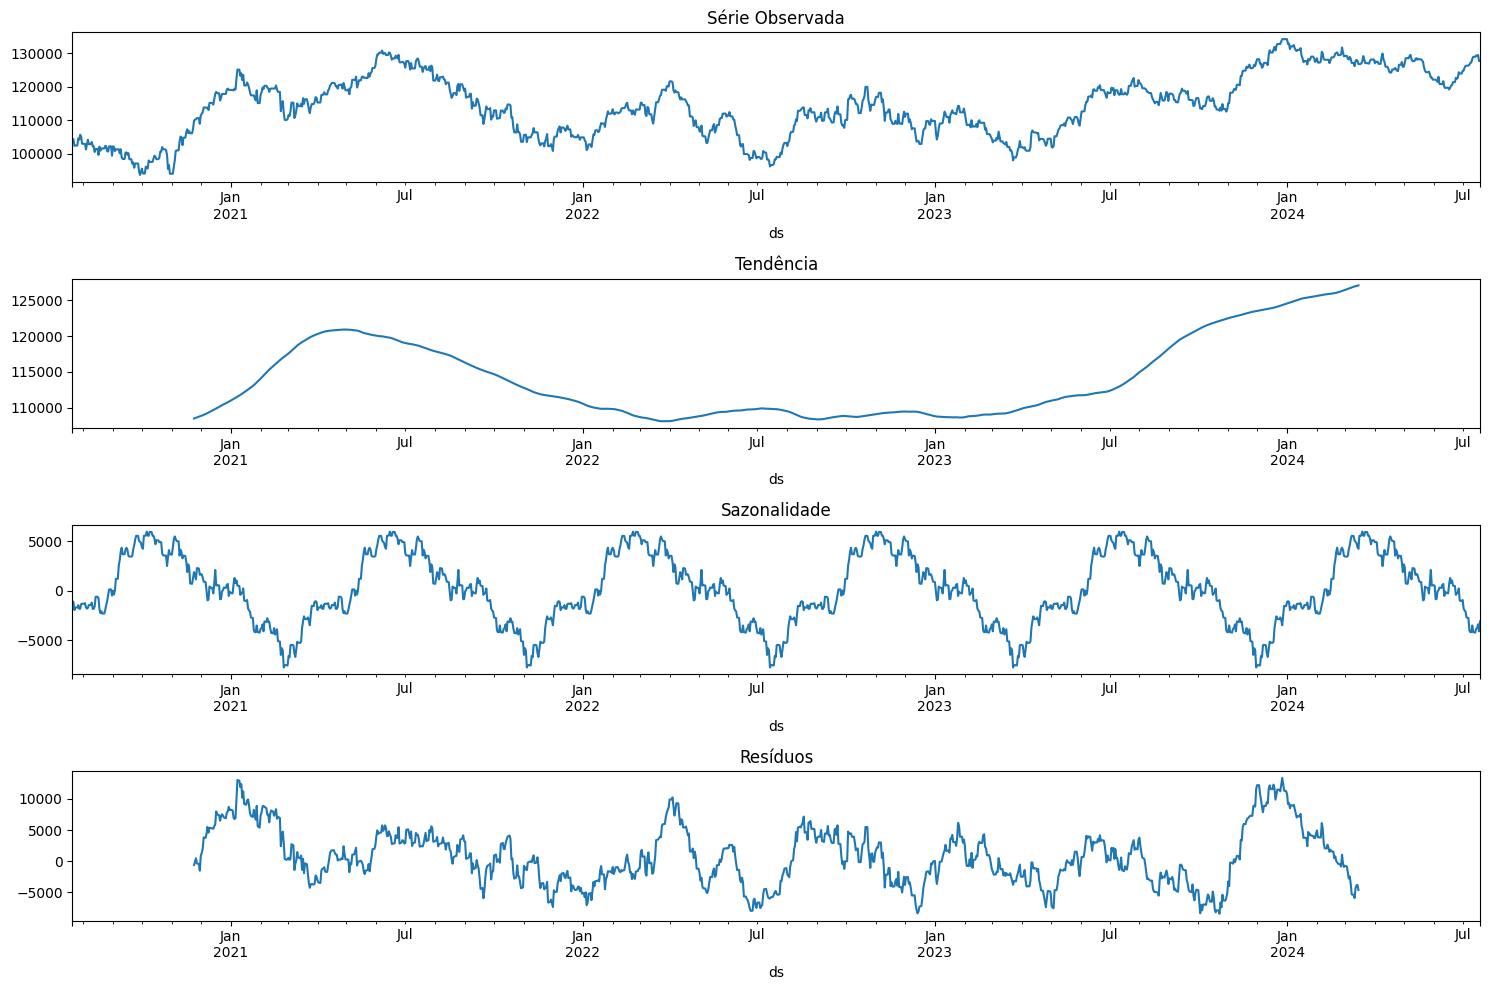

In [313]:
# period = 252 corresponde a quantidade de dias de um ano útil
resultados = seasonal_decompose(df_diario['y'], model='additive',period=252)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_title('Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_title('Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_title('Resíduos')

plt.tight_layout()

### Análise do Seasonal Decompese

**Gráfico da Série Observada:**

O gráfico da série observada mostra o comportamento do índice IBOVESPA ao longo do tempo, com dados diários. Podemos notar variações significativas, refletindo a volatilidade típica do mercado de ações.

**Gráfico da Tendência:**

O componente de tendência captura o movimento geral de longo prazo do índice. Observamos um aumento inicial até aproximadamente o meio de 2021, seguido por uma tendência de queda até o início de 2023. A partir daí, a tendência volta a subir até o final do período observado em 2024. Essa informação é útil para entender a direção geral do mercado ao longo do tempo, mostrando que acontecimentos externos influenciam de forma significativa essa tendência, como a pandemia da COVID-19.

**Gráfico da Sazonalidade:**

O componente sazonal mostra padrões que se repetem em intervalos regulares. Considerando que o índice IBOVESPA têm registros somente nos dias úteis, para esse gráfico utilizamos o parâmetro de periodo com o valor de 252 dias, o que corresponde aproximadamente ao total de dias úteis de um ano. Diante dessa configuração, conseguimos visualizar uma sazonalidade que se repete aproximadamente a cada ano.

**Gráfico de Resíduos:**

Como o gráfico de resíduos representa o que resta da série temporal após a remoção dos componentes de tendência e sazonalidade, o ideal é que os resíduos devem parecer ruído branco, sem padrões visíveis, o que é identificado no gráfico exposto.

## Análise da tendência

In [314]:
df_tendencia = df_diario.reset_index().copy()

df_tendencia['data_ordinal'] = df_tendencia['ds'].map(pd.Timestamp.toordinal)

X = df_tendencia[['data_ordinal']]
y = df_tendencia['y']

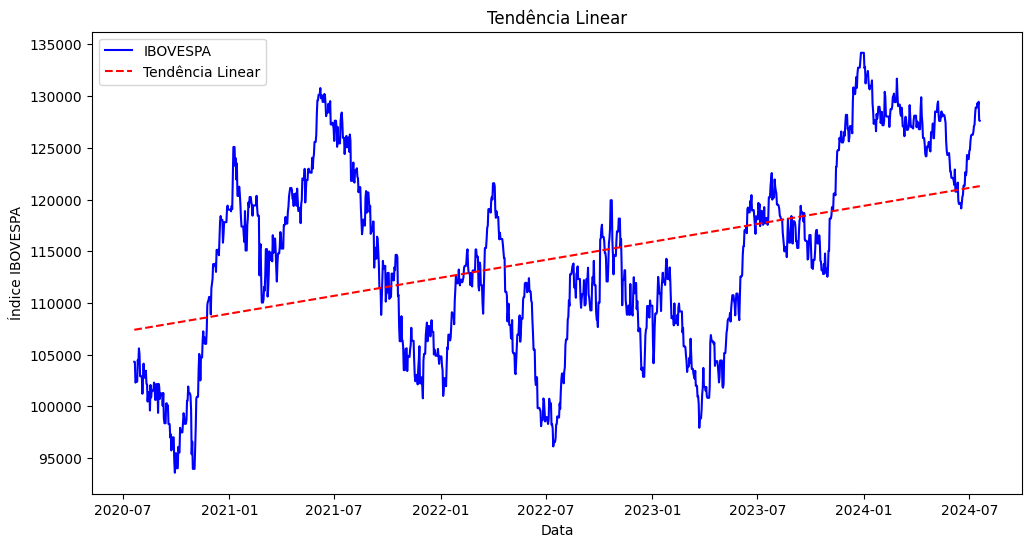

In [315]:
model = LinearRegression()
model.fit(X, y)

# Previsões
df_tendencia['tendencia'] = model.predict(X)

# Plotar os dados
plt.figure(figsize=(12, 6))
plt.plot(df_tendencia['ds'], df_tendencia['y'], label='IBOVESPA', color='blue')
plt.plot(df_tendencia['ds'], df_tendencia['tendencia'], label='Tendência Linear', color='red', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Índice IBOVESPA')
plt.title('Tendência Linear')
plt.legend()
plt.show()

### Análise do Gráfico de Tendência Linear

Utizamos o Modelo de Regressão Linear para verificar a tendência da série temporal analisada. Conforme exposto no gráfico acima, verificamos que a série possui uma tendência de crescimento. Sendo um comportamento esperado à longo prazo de séries temporais que representam índices de bolsas de valores.

## Análise da Média Movel de 30 dias

In [316]:
# Médias movéis
df_medias_moveis = df_diario.copy()
# Calcular médias móveis
df_medias_moveis['MA30'] = df_medias_moveis['y'].rolling(window=30).mean()

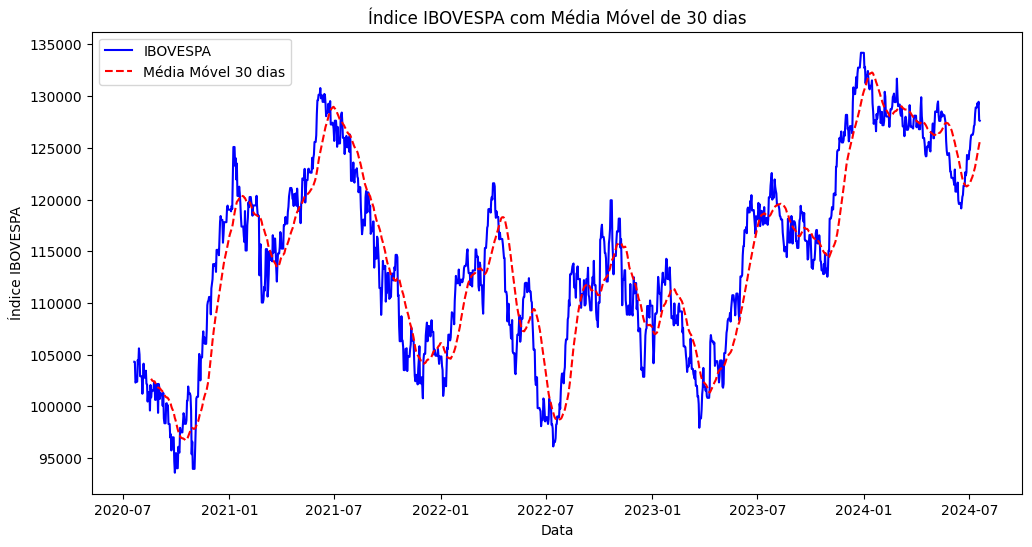

In [317]:
plt.figure(figsize=(12, 6))

# Plotar o índice IBOVESPA
plt.plot(df_medias_moveis.index, df_medias_moveis['y'], label='IBOVESPA', color='blue')

# Plotar as médias móveis
plt.plot(df_medias_moveis.index, df_medias_moveis['MA30'], label='Média Móvel 30 dias', color='red', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Índice IBOVESPA')
plt.title('Índice IBOVESPA com Média Móvel de 30 dias')
plt.legend()
plt.show()

### Análise do Gráfico Índice IBOVESPA com Média Movel de 30 dias

A linha vermelha tracejada mostra a média móvel de 30 dias do índice IBOVESPA. A média móvel suaviza as flutuações diárias, facilitando a identificação de tendências subjacentes.
A média móvel de 30 dias acompanha bem as tendências gerais da série temporal, eliminando os picos e vales extremos e apresentando uma visão mais clara dos movimentos de longo prazo.
Observa-se que a média móvel de 30 dias é mais suave e revela padrões mais consistentes, como a tendência de queda em 2021 e a recuperação posterior.

## Auto correlação

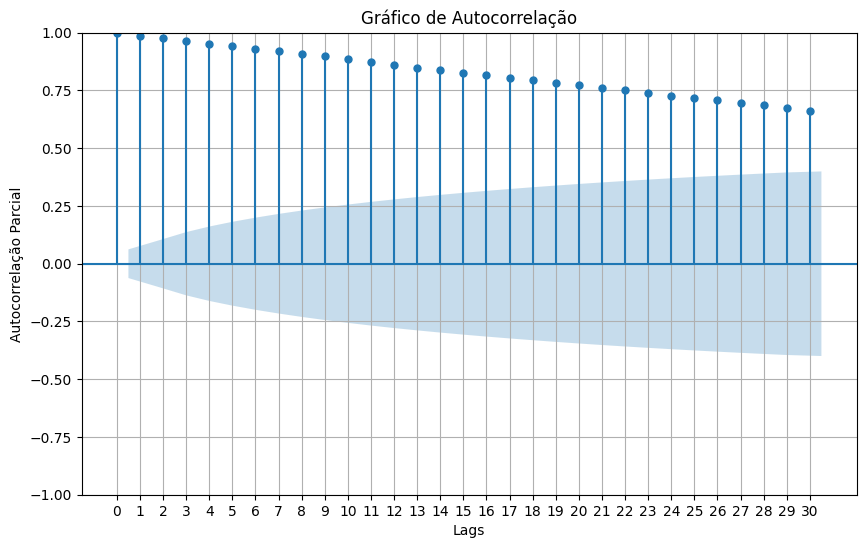

In [318]:
# Plotar o gráfico de autocorrelação parcial com personalizações
fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico de autocorrelação parcial
plot_acf(df_novo['y'], ax=ax)

# Adicionar grade
ax.grid(True)

# Diminuir o intervalo de ticks
ax.set_xticks(range(0, 31, 1))  # Ajustar o intervalo de ticks no eixo X para cada lag de 1 a 30

# Títulos e rótulos
ax.set_title('Gráfico de Autocorrelação')
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrelação Parcial')

plt.show()


### Análise do Gráfico de Auto Correlação

Observamos no gráfico de Auto Correlação que a primeira barra vertical é igual 1 o que indica uma alta correlação entre os valores consecutivos da série temporal. As barras verticais decresce a medida que os números de lags aumenta, mas ainda permanecem acima de 0.75 até o lag 22, isso sugere que há uma forte correlação positiva entre os valores da série temporal para lags relativamente longos.

É possível observar também que as barras verticais estão acima do intervalo de confiança, indicando que as altas correlações são estatiscamente significativas. A persistência dessa correlação acima do intervalo de confiança sugere que a série temporal tem uma estrutura de dependência forte e não é aleatória.

A auto correlação positiva e lenta diminuição das barras indicam que a série temporal provavelmente não é estacionário e pode ter um tendência.

## Auto Correlação Parcial

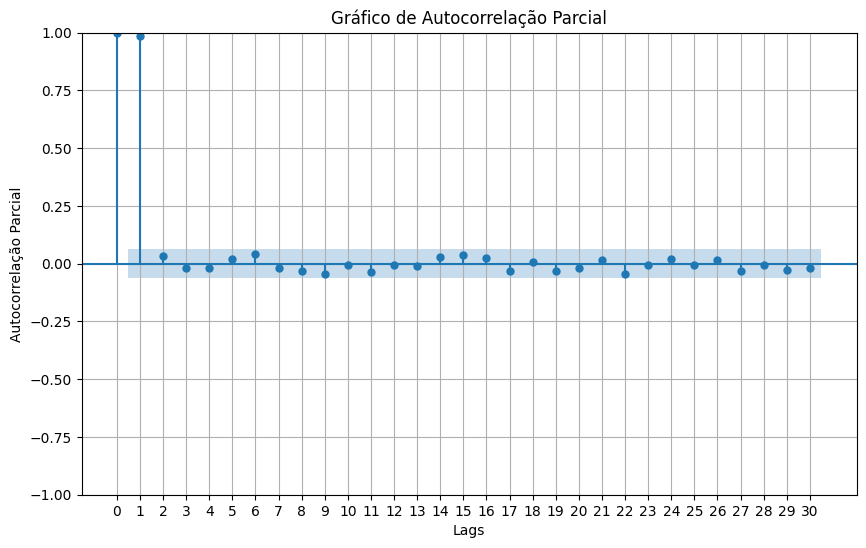

In [319]:
# Plotar o gráfico de autocorrelação parcial com personalizações
fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico de autocorrelação parcial
plot_pacf(df_novo['y'], ax=ax)

# Adicionar grade
ax.grid(True)

# Diminuir o intervalo de ticks
ax.set_xticks(range(0, 31, 1))  # Ajustar o intervalo de ticks no eixo X para cada lag de 1 a 30

# Títulos e rótulos
ax.set_title('Gráfico de Autocorrelação Parcial')
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrelação Parcial')

plt.show()


### Análise do Gráfico de Correlação Parcial

Observamos que as barras caem drasticamente após o lag 1 e permanecem próximas de zero, o que indica que a série temporal não possui uma forte autocorrelação parcial além do primeiro lag. Isso sugere que a maior parte da correlação na série está explicada pelos valores no lag 1.

As barras estão próximas de zero e dentro dos intervalos de confiança a partir do lag 2. Isso significa que as correlações parciais para esses lags não são estatisticamente significativas.

Concluímos então que apenas até a lag 1 tem significância estatistica.

## Estacionariedade

Os gráficos de ACF e PACF sugeriram a não estacionariedade. Contudo, iremos utilizar o método de Dick Fuller para confirmar.

In [320]:
# Estacionária ou não estacionária

# ADF - Augmented Dickey Fuller

# H0 - Hipótese Nula (não é estacionária)
# H1 - Hipótese Alternativa (rejeição da hipótese nula)

# p -value = 0.05 (5%), então rejeitamos H0 com um nível de confiança de 95%

X = df_novo.y.values
resultado_adf = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {resultado_adf[0]}")
print(f"P-Value: {resultado_adf[1]}")
print("Valores críticos:")

for key, value in resultado_adf[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.204784030301742
P-Value: 0.2045137141109739
Valores críticos:
	1%: -3.4369391965679257
	5%: -2.86444914142694
	10%: -2.5683189679553546


### Análise do Resultado do método de Dick Fuller

O p-valor de 0.2045137141109739 é maior que 0.05, indicando que não há evidência suficiente para rejeitar a hipótese nula de não estacionaridade.

Além disso, o teste estatístico (-2.204784030301742) é maior do que todos os valores críticos (em termos absolutos), especialmente o valor crítico de 5% (-2.86444914142694) e o valor crítico de 10% (-2.5683189679553546).

Confirmando assim, que não podemos rejeitar a hipótese nula de que a série tem uma raiz unitária (não é estacionária).

## Diferenciação para tornar a série estacionária

In [321]:
# Estacionária ou não estacionária

# ADF - Augmented Dickey Fuller

# H0 - Hipótese Nula (não é estacionária)
# H1 - Hipótese Alternativa (rejeição da hipótese nula)

# p -value = 0.05 (5%), então rejeitamos H0 com um nível de confiança de 95%

df_diff = df_novo.diff().dropna()

X = df_diff.y.values
resultado_adf = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {resultado_adf[0]}")
print(f"P-Value: {resultado_adf[1]}")
print("Valores críticos:")

for key, value in resultado_adf[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -32.959911372270746
P-Value: 0.0
Valores críticos:
	1%: -3.43694584277544
	5%: -2.8644520725172873
	10%: -2.5683205291305176


### Análise da Diferenciação

Com apenas uma diferenciação foi possível rejeitar a hipótese nula (p-value menor 0.05). Indicando que a série se tornou estacionário com apenas uma diferenciação.

## Funções para calcular e imprimir as métricas de erros

As métricas escolhidas foram o Erro Médio Absoluto (MAE), Erro Quadrático Médio (MSE) e Erro Percentual Absoluto Médio (MAPE).

In [322]:
def calculate_errors(y_true, y_pred):
    """
    Calcula o MAE, MSE e MAPE.

    Parâmetros:
    y_true (array-like): Valores reais.
    y_pred (array-like): Valores previstos.

    Retorna:
    dict: Um dicionário contendo MAE, MSE e MAPE.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {'MAE': mae, 'MSE': mse, 'MAPE': mape}

In [323]:
def print_errors(y_true, y_pred):
    """
    Calcula e imprime os erros MAE, MSE e MAPE.

    Parâmetros:
    y_true (array-like): Valores reais.
    y_pred (array-like): Valores previstos.
    """
    errors = calculate_errors(y_true, y_pred)

    print(f"MAE (Mean Absolute Error): {errors['MAE']}")
    print(f"MSE (Mean Squared Error): {errors['MSE']}")
    print(f"MAPE (Mean Absolute Percentage Error): {errors['MAPE']}%")

## Dividindo o dataset em treino e validação

Divimos o dataset em treino e validação para criarmos os modelos. Decidimos iniciar o dataset de validação em uma quarta-feira (10/07/2024), para que a validação não iniciasse no final de semana, onde os valores são iguais à sexta-feira anterior. Além disso, definimos o tamanho desse dataset de validação em 7 dias (10/07/2024 a 16/07/2024).

In [324]:
df_modelo = df_diario.copy()

In [325]:
# Dividir o dataframe em treino e validação (usando para validação 7 dias começando no meio da semana)
train_size = df_modelo.shape[0] -10
train_df = df_modelo[:train_size]#.astype(int)
val_df = df_modelo[train_size:-3]#.astype(int)

In [326]:
train_df.tail(9)

,y,abertura
ds,,
2024-07-01,124718,123905
2024-07-02,124787,124720
2024-07-03,125662,124787
2024-07-04,126164,125666
2024-07-05,126267,126165
2024-07-06,126267,126165
2024-07-07,126267,126165
2024-07-08,126548,126280
2024-07-09,127108,126548


In [327]:
val_df

,y,abertura
ds,,
2024-07-10,127218,127109
2024-07-11,128294,127221
2024-07-12,128897,128293
2024-07-13,128897,128293
2024-07-14,128897,128293
2024-07-15,129321,128898
2024-07-16,129110,129322


In [328]:
len(val_df)

7

##Modelo **ARIMA**

O modelo ARIMA (Autoregressive Integrated Moving Average), utilizado para previsão de séries temporais, combina três componentes: AR (Autoregressive) com parâmetro
𝑝
(número de lags), I (Integrated) com parâmetro
𝑑
(número de diferenciações para estacionariedade), e MA (Moving Average) com parâmetro
𝑞
(número de termos de erro).

**Escolha dos Hiperparâmetros:**


p (Autoregressive): É utilizada a função de autocorrelação parcial (PACF) para identificar o número de lags. Retornando ao gráfico PACF identificamos o valor do parâmetro é igual a 1.

d (Integrated): Utilizamos o teste de Dickey-Fuller para determinar a necessidade de diferenciação e verificamos que apenas uma diferenciação torna a série estacionária.

q (Moving Average): Verificamos na literatura que a sugestão seria começar com valores baixos e aumentar conforme necessário, contudo valores muito altos demandam alto processamento. Chegamos a um valor de 7 como satisfatório.

In [329]:
# Treinar o modelo ARIMA
# (p, d, q) - são provenientes da análise dos gráficos ACF e PACF
model_arima = ARIMA(train_df['y'], order=(1,1,7))
model_fit_arima = model_arima.fit()

In [330]:
# Fazer previsões para o período de validação
forecast_start = len(train_df['y'])
forecast_end = forecast_start + len(val_df) - 1
forecast_arima = model_fit_arima.predict(start=forecast_start, end=forecast_end, typ='levels').astype(int)

In [331]:
# Transformar o forecast em uma Série e garantir que o índice esteja correto
forecast_series_arima = pd.Series(forecast_arima, index=val_df.index)

In [332]:
forecast_series_arima.head()

ds
2024-07-10    127072
2024-07-11    127060
2024-07-12    127057
2024-07-13    127058
2024-07-14    127066
Freq: D, Name: predicted_mean, dtype: int64

In [333]:
# Calcular o erro de previsão
erros_arima = calculate_errors(val_df['y'], forecast_series_arima)
print_errors(val_df['y'], forecast_series_arima)

MAE (Mean Absolute Error): 1599.4285714285713
MSE (Mean Squared Error): 2993567.4285714286
MAPE (Mean Absolute Percentage Error): 1.2405201804801975%


In [334]:
# Selecionar os últimos 14 registros de cada DataFrame
last_14_train = train_df.iloc[-14:]

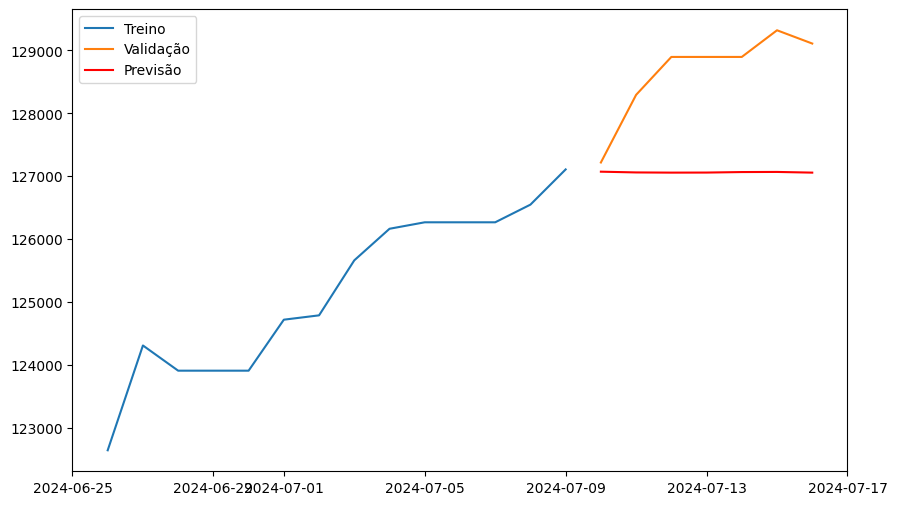

In [335]:
# Plotar resultados
plt.figure(figsize=(10, 6))
plt.plot(last_14_train.index, last_14_train['y'], label='Treino')
plt.plot(val_df.index, val_df['y'], label='Validação')
plt.plot(forecast_series_arima.index, forecast_series_arima, label='Previsão', color='red')
plt.legend()
plt.show()

## Modelo **SARIMA**

Verificamos com o algoritmo abaixo que os melhores valores para os hiperparâmetros são:

p=0, d=1, q=0, P=0, D=0, Q=1, s=7

In [336]:
# Definir intervalo de valores para os hiperparâmetros
"""
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = [7]  # Períodos sazonais típicos

best_aic = np.inf
best_params = None
best_model = None

for p_val in p:
    for d_val in d:
        for q_val in q:
            for P_val in P:
                for D_val in D:
                    for Q_val in Q:
                        for s_val in s:
                            try:
                                # Ajustar o modelo SARIMA
                                model_sarima = SARIMAX(train_df['y'], order=(p_val, d_val, q_val),
                                                seasonal_order=(P_val, D_val, Q_val, s_val))
                                model_fit_sarima = model_sarima.fit(disp=False)

                                # Calcular o AIC
                                aic = model_fit_sarima.aic

                                # Comparar com o melhor AIC encontrado
                                if aic < best_aic:
                                    best_aic = aic
                                    best_params = (p_val, d_val, q_val, P_val, D_val, Q_val, s_val)
                                    best_model = model_fit_sarima
                            except:
                                continue

print(f'Best AIC: {best_aic}')
print(f'Best Parameters: p={best_params[0]}, d={best_params[1]}, q={best_params[2]}, '
      f'P={best_params[3]}, D={best_params[4]}, Q={best_params[5]}, s={best_params[6]}')
"""


"\np = d = q = range(0, 3)\nP = D = Q = range(0, 2)\ns = [7]  # Períodos sazonais típicos\n\nbest_aic = np.inf\nbest_params = None\nbest_model = None\n\nfor p_val in p:\n    for d_val in d:\n        for q_val in q:\n            for P_val in P:\n                for D_val in D:\n                    for Q_val in Q:\n                        for s_val in s:\n                            try:\n                                # Ajustar o modelo SARIMA\n                                model_sarima = SARIMAX(train_df['y'], order=(p_val, d_val, q_val),\n                                                seasonal_order=(P_val, D_val, Q_val, s_val))\n                                model_fit_sarima = model_sarima.fit(disp=False)\n\n                                # Calcular o AIC\n                                aic = model_fit_sarima.aic\n\n                                # Comparar com o melhor AIC encontrado\n                                if aic < best_aic:\n                                    be

In [337]:
model_sarima = SARIMAX(train_df['y'], order=(0, 1, 0), seasonal_order=(0, 0, 1, 7))
model_fit_sarima = model_sarima.fit(disp=False)

In [338]:
# Fazer previsões para o período de validação
forecast_sarima = model_fit_sarima.get_forecast(steps=len(val_df))
forecast_series_sarima = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

In [339]:
# Calcular o erro de previsão
erros_sarima = calculate_errors(val_df['y'], forecast_series_sarima)
print_errors(val_df['y'], forecast_series_sarima)

MAE (Mean Absolute Error): 1593.5155897276065
MSE (Mean Squared Error): 2981995.092176362
MAPE (Mean Absolute Percentage Error): 1.2359024032012016%


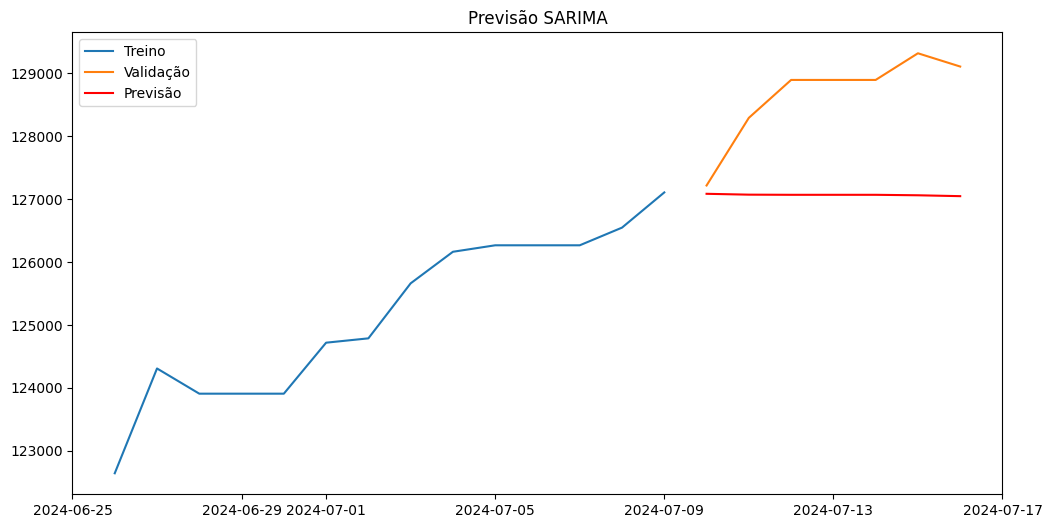

In [340]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(last_14_train.index, last_14_train['y'], label='Treino')
plt.plot(val_df.index, val_df['y'], label='Validação')
plt.plot(forecast_series_sarima.index, forecast_series_sarima, label='Previsão', color='red')
plt.legend()
plt.title('Previsão SARIMA')
plt.show()

## Modelo **ExponentialSmoothing**

In [341]:
# Ajustar o modelo Holt-Winters (Exponential Smoothing)
# Configurações: tendência aditiva e sazonalidade aditiva, sazonalidade diária
model_exp_smoo = ExponentialSmoothing(train_df['y'], trend='add', seasonal='add', seasonal_periods=7)
model_fit_exp_smoo = model_exp_smoo.fit()

In [342]:
# Fazer previsões para o período de validação
forecast_exp_smoo = model_fit_exp_smoo.forecast(steps=len(val_df))

In [343]:
# Transformar o forecast em uma Série e garantir que o índice esteja correto
forecast_series_exp_smoo = pd.Series(forecast_exp_smoo, index=val_df.index)

In [344]:
# Calcular o erro de previsão
erros_exp_smoo = calculate_errors(val_df['y'], forecast_series_exp_smoo)
print_errors(val_df['y'], forecast_series_exp_smoo)

MAE (Mean Absolute Error): 1482.5118021208598
MSE (Mean Squared Error): 2562308.665361341
MAPE (Mean Absolute Percentage Error): 1.1498852823763492%


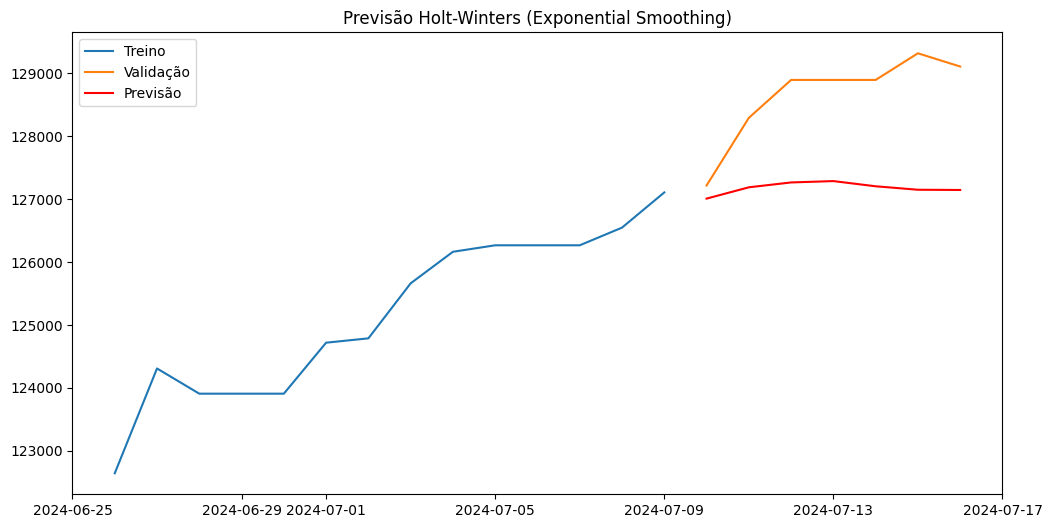

In [345]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(last_14_train.index, last_14_train['y'], label='Treino')
plt.plot(val_df.index, val_df['y'], label='Validação')
plt.plot(forecast_series_exp_smoo.index, forecast_series_exp_smoo, label='Previsão', color='red')
plt.legend()
plt.title('Previsão Holt-Winters (Exponential Smoothing)')
plt.show()

## Modelo **Prophet**

In [346]:
df_modelo_prophet = df_modelo.reset_index()
df_modelo_prophet

,ds,y,abertura
0,2020-07-21,104310,104426
1,2020-07-22,104290,104312
2,2020-07-23,102293,104291
3,2020-07-24,102382,102292
4,2020-07-25,102382,102292
...,...,...,...
1455,2024-07-15,129321,128898
1456,2024-07-16,129110,129322
1457,2024-07-17,129450,129112
1458,2024-07-18,127652,129450


In [347]:
# Dividir o dataframe em treino e validação
train_size_prophet = df_modelo_prophet.shape[0] - 10
train_df_prophet = df_modelo_prophet[:train_size_prophet]
val_df_prophet = df_modelo_prophet[train_size_prophet:-3]


In [348]:
val_df_prophet.isnull().sum()

ds          0
y           0
abertura    0
dtype: int64

In [349]:
# Ajustar o modelo Prophet
#TO-DO: Faxer teste combinatorial para achar os melhores hiperparâmetros
model_prophet = Prophet(#seasonality_mode= 'additive',#'multiplicative',
                      #yearly_seasonality=False,
                      weekly_seasonality=True,
                      #daily_seasonality=True
                      )
#TO_DO: Trecho para incluir mais um dado. Talvez aqui incluir o valor do índice na abertura ou outro dado relevante
model_prophet.add_regressor("abertura")
model_prophet.fit(train_df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1k3cbpl/er8whuym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1k3cbpl/c3c7go5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37339', 'data', 'file=/tmp/tmpr1k3cbpl/er8whuym.json', 'init=/tmp/tmpr1k3cbpl/c3c7go5b.json', 'output', 'file=/tmp/tmpr1k3cbpl/prophet_model4f4djjd0/prophet_model-20240727171733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [350]:
# Fazer previsões para o período de validação
future = model_prophet.make_future_dataframe(periods=len(val_df_prophet))
# Adicionar o regressor correspondente ao futuro DataFrame
future['abertura'] = val_df_prophet['abertura'].astype(int)
future['abertura'] = future['abertura'].fillna(0).astype(int)
forecast_prophet = model_prophet.predict(future)

In [351]:
# Extrair as previsões para o período de validação
forecast_val = forecast_prophet[['ds', 'yhat']].set_index('ds').loc[val_df_prophet['ds']]

In [352]:
# Calcular o erro de previsão
erros_prophet = calculate_errors(val_df_prophet['y'], forecast_val['yhat'])
print_errors(val_df_prophet['y'],forecast_val['yhat'])

MAE (Mean Absolute Error): 589.6697846688413
MSE (Mean Squared Error): 432613.1157362806
MAPE (Mean Absolute Percentage Error): 0.4579791256110229%


In [353]:
# Selecionar os últimos 14 registros de cada DataFrame
last_14_train = train_df_prophet.iloc[-14:]

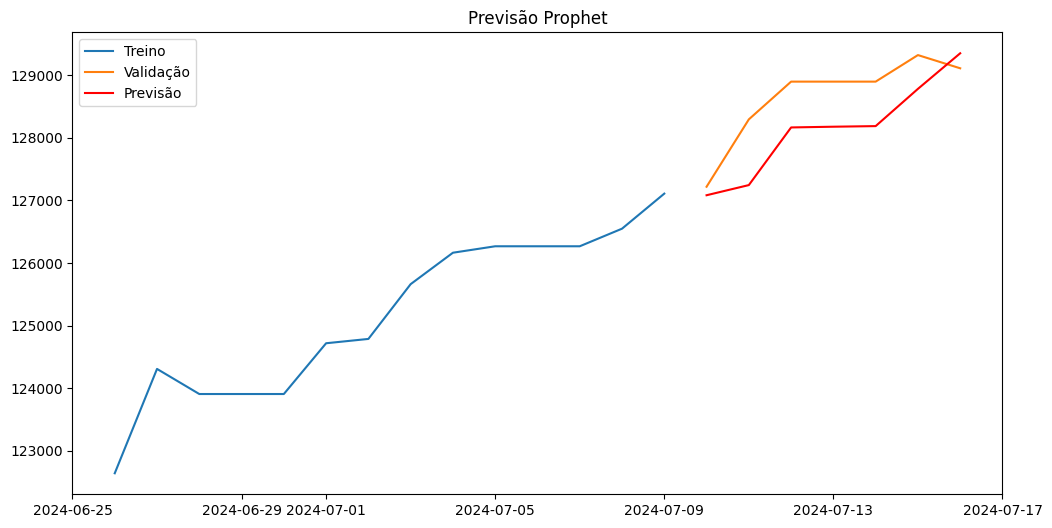

In [354]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(last_14_train['ds'], last_14_train['y'], label='Treino')
plt.plot(val_df_prophet['ds'], val_df_prophet['y'], label='Validação')
plt.plot(forecast_val.index, forecast_val['yhat'], label='Previsão', color='red')
plt.legend()
plt.title('Previsão Prophet')
plt.show()

## Modelo **SARIMAX**

Incorpora valore exôgenos

In [355]:
exog_train = train_df[["abertura"]]
exog_val = val_df[["abertura"]]

In [356]:
exog_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1450 entries, 2020-07-21 to 2024-07-09
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   abertura  1450 non-null   int64
dtypes: int64(1)
memory usage: 22.7 KB


In [357]:
model_sarimax = SARIMAX(train_df['y'], exog =exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit_sarimax = model_sarimax.fit()

In [358]:
# Fazer previsões para o período de validação
forecast_sarimax = model_fit_sarimax.get_forecast(steps=len(val_df),exog = exog_val).predicted_mean

In [359]:
forecast_sarimax

2024-07-10    127267.076075
2024-07-11    127186.914887
2024-07-12    128099.817029
2024-07-13    128150.022980
2024-07-14    127869.139226
2024-07-15    128426.398640
2024-07-16    128981.733138
Freq: D, Name: predicted_mean, dtype: float64

In [360]:
# Calcular o erro de previsão
erros_sarimax = calculate_errors(val_df['y'], forecast_sarimax)
print_errors(val_df['y'],forecast_sarimax)

MAE (Mean Absolute Error): 678.7214535774817
MSE (Mean Squared Error): 613540.431112001
MAPE (Mean Absolute Percentage Error): 0.5268610511462009%


In [361]:
# Selecionar os últimos 14 registros de cada DataFrame
last_14_train = train_df.iloc[-14:]

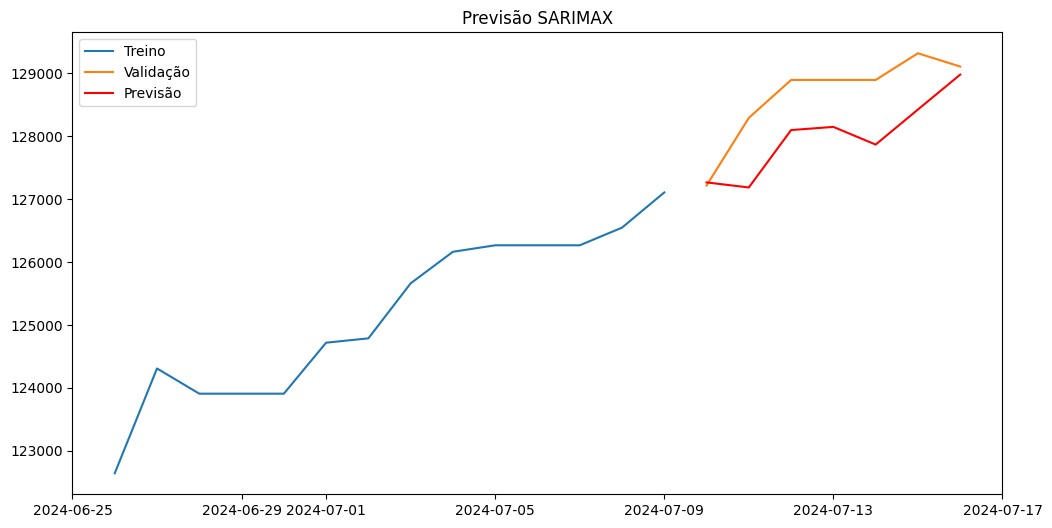

In [362]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(last_14_train.index, last_14_train['y'], label='Treino')
plt.plot(val_df.index, val_df['y'], label='Validação')
plt.plot(val_df.index, forecast_sarimax, label='Previsão', color='red')
plt.legend()
plt.title('Previsão SARIMAX')
plt.show()

## Modelo **XGBoost**

In [363]:
df_modelo_xg = df_modelo_prophet.copy()

In [364]:
df_modelo_xg

,ds,y,abertura
0,2020-07-21,104310,104426
1,2020-07-22,104290,104312
2,2020-07-23,102293,104291
3,2020-07-24,102382,102292
4,2020-07-25,102382,102292
...,...,...,...
1455,2024-07-15,129321,128898
1456,2024-07-16,129110,129322
1457,2024-07-17,129450,129112
1458,2024-07-18,127652,129450


In [365]:
# Criar features baseadas em lags (atrasos)
df_modelo_xg["year"] = df_modelo_xg["ds"].dt.year
df_modelo_xg["month"] = df_modelo_xg["ds"].dt.month
df_modelo_xg["day"] = df_modelo_xg["ds"].dt.day
df_modelo_xg["day_of_week"] = df_modelo_xg["ds"].dt.dayofweek


In [366]:
FEATURES = ["year","month","day","day_of_week"]
TARGET = "y"

In [367]:
df_modelo_xg

,ds,y,abertura,year,month,day,day_of_week
0,2020-07-21,104310,104426,2020,7,21,1
1,2020-07-22,104290,104312,2020,7,22,2
2,2020-07-23,102293,104291,2020,7,23,3
3,2020-07-24,102382,102292,2020,7,24,4
4,2020-07-25,102382,102292,2020,7,25,5
...,...,...,...,...,...,...,...
1455,2024-07-15,129321,128898,2024,7,15,0
1456,2024-07-16,129110,129322,2024,7,16,1
1457,2024-07-17,129450,129112,2024,7,17,2
1458,2024-07-18,127652,129450,2024,7,18,3


In [368]:
train_size = df_modelo_xg.shape[0] - 10
train_df = df_modelo_xg[:train_size]
val_df = df_modelo_xg[train_size:-3]

In [369]:
val_df

,ds,y,abertura,year,month,day,day_of_week
1450,2024-07-10,127218,127109,2024,7,10,2
1451,2024-07-11,128294,127221,2024,7,11,3
1452,2024-07-12,128897,128293,2024,7,12,4
1453,2024-07-13,128897,128293,2024,7,13,5
1454,2024-07-14,128897,128293,2024,7,14,6
1455,2024-07-15,129321,128898,2024,7,15,0
1456,2024-07-16,129110,129322,2024,7,16,1


In [370]:
# Preparar os dados para XGBoost
x_train, y_train = train_df[FEATURES],train_df[TARGET]
x_val, y_val = val_df[FEATURES], val_df[TARGET]

In [371]:
train_df.head()

,ds,y,abertura,year,month,day,day_of_week
0,2020-07-21,104310,104426,2020,7,21,1
1,2020-07-22,104290,104312,2020,7,22,2
2,2020-07-23,102293,104291,2020,7,23,3
3,2020-07-24,102382,102292,2020,7,24,4
4,2020-07-25,102382,102292,2020,7,25,5


In [372]:
# Ajustar o modelo XGBoost
model_xg = XGBRegressor(objective='reg:squarederror')
model_xg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [373]:
# Fazer previsões para o período de validação
y_pred = model_xg.predict(x_val)

In [374]:
# Calcular o erro de previsão
erros_xg = calculate_errors(y_val, y_pred)
print_errors(y_val,y_pred)

MAE (Mean Absolute Error): 3315.0401785714284
MSE (Mean Squared Error): 12924148.078526089
MAPE (Mean Absolute Percentage Error): 2.571417270474337%


In [375]:
# Selecionar os últimos 14 registros de cada DataFrame
last_14_train = train_df.iloc[-14:]

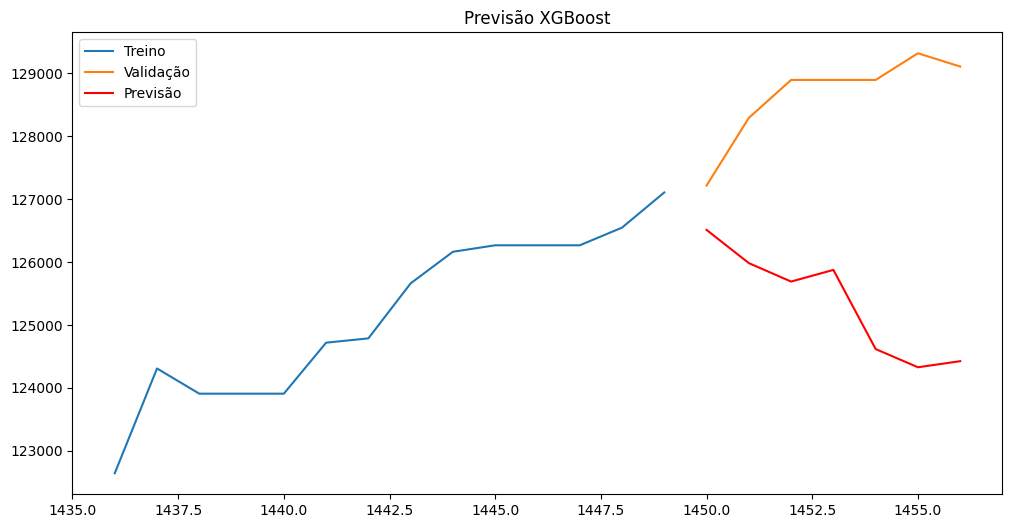

In [376]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(last_14_train.index, y_train.iloc[-14:], label='Treino')
plt.plot(val_df.index, y_val, label='Validação')
plt.plot(val_df.index, y_pred, label='Previsão', color='red')
plt.legend()
plt.title('Previsão XGBoost')
plt.show()

## Comparação dos Resultados

In [377]:
df_resultado = pd.DataFrame(
    [erros_arima,erros_sarima,erros_exp_smoo,erros_prophet,erros_sarimax,erros_xg],
    columns=['MAE','MSE','MAPE'],
    index=["Arima","Sarima"," Exponential Smoothing","Prophet","Sarimax","XGBoost"]
)
df_resultado

,MAE,MSE,MAPE
Arima,1599.428571,2.993567e+06,1.240520
Sarima,1593.515590,2.981995e+06,1.235902
Exponential Smoothing,1482.511802,2.562309e+06,1.149885
Prophet,589.669785,4.326131e+05,0.457979
Sarimax,678.721454,6.135404e+05,0.526861
XGBoost,3315.040179,1.292415e+07,2.571417


### Análise dos resultados dos modelos

Caros investidores, como podem perceber utilizamos alguns modelos disponíveis para realizar os treinos, apenas para mostrar para os senhores as opções disponíveis e seus respectivos desempenho.

Na tabela abaixo, comparando os resultados podemos verificar que o Prophet obteve o melhor desempenho, com aproximadamente 0.46% de Erro Percentual Absoluto Médio (MAPE). Considerando assim, uma acurácia de 99.54%.

O modelo Prophet, desenvolvido pelo Facebook, projetado para lidar com dados que apresentam sazonalidade e tendências. Apesar desse modelo não está sendo mais evoluído desde 2023, optamos por aprimorar a escolha dos hiperparâmetros do Prophet para tentar alcançar um resultado ainda melhor.

## Encontrando os melhores **hiperparâmetros** para o **Prophet**

In [378]:
df_modelo_prophet = df_novo.reset_index()

# Dividir o dataframe em treino e validação
train_size_prophet = df_modelo_prophet.shape[0] - 10
train_df_prophet = df_modelo_prophet[:train_size_prophet]
val_df_prophet = df_modelo_prophet[train_size_prophet:-3]

In [379]:
#função para criar o modelo prophet:
def create_model(params):
    model = Prophet(
        changepoint_prior_scale=params.get('changepoint_prior_scale', 0.05),
        seasonality_mode=params.get('seasonality_mode', 'additive'),
        seasonality_prior_scale=params.get('seasonality_prior_scale', 10.0),
        holidays_prior_scale=params.get('holidays_prior_scale', 10.0),
    )
    return model


In [380]:
#função para avaliar o modelo:
def evaluate_model(model, X, y):
    model.fit(X)
    future = model.make_future_dataframe(periods=len(y), include_history=False)
    forecast = model.predict(future)
    y_pred = forecast['yhat'].values
    return mean_absolute_error(y, y_pred)


In [381]:
#Definindo os hiperparâmetros:
param_distributions = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
}


In [382]:
#Função para criar estimador
class ProphetEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, changepoint_prior_scale=0.05, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0):
        self.changepoint_prior_scale = changepoint_prior_scale
        self.seasonality_mode = seasonality_mode
        self.seasonality_prior_scale = seasonality_prior_scale
        self.holidays_prior_scale = holidays_prior_scale
        self.model = self.create_model()

    def create_model(self):
        return Prophet(
            changepoint_prior_scale=self.changepoint_prior_scale,
            seasonality_mode=self.seasonality_mode,
            seasonality_prior_scale=self.seasonality_prior_scale,
            holidays_prior_scale=self.holidays_prior_scale
        )

    def fit(self, X, y):
        df = pd.DataFrame({'ds': X, 'y': y})
        self.model.fit(df)
        return self

    def predict(self, X):
        future = pd.DataFrame({'ds': X})
        forecast = self.model.predict(future)
        return forecast['yhat']

    def get_params(self, deep=True):
        return {
            'changepoint_prior_scale': self.changepoint_prior_scale,
            'seasonality_mode': self.seasonality_mode,
            'seasonality_prior_scale': self.seasonality_prior_scale,
            'holidays_prior_scale': self.holidays_prior_scale
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        self.model = self.create_model()
        return self

# Função para validar o modelo
def validate_model(model, X, y):
    scores = cross_val_score(model, X, y, scoring=make_scorer(mean_absolute_error), cv=5)
    return scores.mean()


In [383]:
param_distributions

{'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
 'seasonality_mode': ['additive', 'multiplicative'],
 'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
 'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]}

In [384]:
#Realizar Randomized Search com Validação Cruzada
# Preparar os dados de treino
X = train_df_prophet['ds']
y = train_df_prophet['y']

# Definir o modelo ProphetEstimator para RandomizedSearchCV
model = ProphetEstimator()

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=10,  # Número de combinações aleatórias a serem testadas
    scoring=make_scorer(mean_absolute_error),
    cv=5,  # Número de folds para validação cruzada
    random_state=42
)

# Executar RandomizedSearchCV
random_search.fit(X, y)

# Exibir os melhores hiperparâmetros e a melhor pontuação
print("Melhores parâmetros encontrados:", random_search.best_params_)
print("Melhor pontuação (MAE):", random_search.best_score_)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1k3cbpl/aquue6fo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1k3cbpl/_4czk2wp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85413', 'data', 'file=/tmp/tmpr1k3cbpl/aquue6fo.json', 'init=/tmp/tmpr1k3cbpl/_4czk2wp.json', 'output', 'file=/tmp/tmpr1k3cbpl/prophet_modeln8qtq6hm/prophet_model-20240727171824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1

Melhores parâmetros encontrados: {'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01, 'changepoint_prior_scale': 0.5}
Melhor pontuação (MAE): 16653.329507144877


In [431]:
train_df_prophet.tail()

,ds,y,abertura
981,2024-07-01,124718,123905
982,2024-07-02,124787,124720
983,2024-07-03,125662,124787
984,2024-07-04,126164,125666
985,2024-07-05,126267,126165


In [385]:
# Ajustar o modelo Prophet
#Melhores parâmetros encontrados: {'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01, 'changepoint_prior_scale': 0.5}
model_prophet_best_param = Prophet(changepoint_range= 0.5,
                                   changepoint_prior_scale= 1.0,
                                   holidays_prior_scale= 0.01,
                                   seasonality_mode= 'additive'
                        )

model_prophet_best_param.add_regressor("abertura")
model_prophet_best_param.fit(train_df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1k3cbpl/ldktd7v5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1k3cbpl/o1x6vjke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39784', 'data', 'file=/tmp/tmpr1k3cbpl/ldktd7v5.json', 'init=/tmp/tmpr1k3cbpl/o1x6vjke.json', 'output', 'file=/tmp/tmpr1k3cbpl/prophet_modelh0aqs8uf/prophet_model-20240727171854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [417]:
# Fazer previsões para o período de validação
future = model_prophet_best_param.make_future_dataframe(periods=len(val_df_prophet),freq='B') #dias uteis
# Adicionar o regressor correspondente ao futuro DataFrame
future['abertura'] = val_df_prophet['abertura'].astype(int)
future['abertura'] = future['abertura'].fillna(0).astype(int)
forecast_prophet_best_param = model_prophet_best_param.predict(future)

In [418]:
print(forecast_prophet_best_param[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds           yhat     yhat_lower     yhat_upper
988 2024-07-10  127390.466399  125660.343767  128993.087020
989 2024-07-11  127551.410439  125926.617224  129199.884241
990 2024-07-12  128477.497104  126775.947176  130236.005926
991 2024-07-15  129119.492855  127411.689700  130736.030074
992 2024-07-16  129669.946542  127959.527889  131314.595019


In [419]:
# Extrair as previsões para o período de validação
forecast_val_best_param = forecast_prophet_best_param[['ds', 'yhat']].set_index('ds').loc[val_df_prophet['ds']]

In [420]:
forecast_val_best_param

,yhat
ds,
2024-07-08,126491.691080
2024-07-09,126891.007584
2024-07-10,127390.466399
2024-07-11,127551.410439
2024-07-12,128477.497104
2024-07-15,129119.492855
2024-07-16,129669.946542


In [390]:
# Calcular o erro de previsão
erros_prophet_best_param = calculate_errors(val_df_prophet['y'], forecast_val_best_param['yhat'].round().astype(int))
print_errors(val_df_prophet['y'],forecast_val_best_param['yhat'].round().astype(int))

MAE (Mean Absolute Error): 338.57142857142856
MSE (Mean Squared Error): 166094.57142857142
MAPE (Mean Absolute Percentage Error): 0.2635847397366094%


In [391]:
# Selecionar os últimos 14 registros de cada DataFrame
last_14_train = train_df_prophet.iloc[-14:]

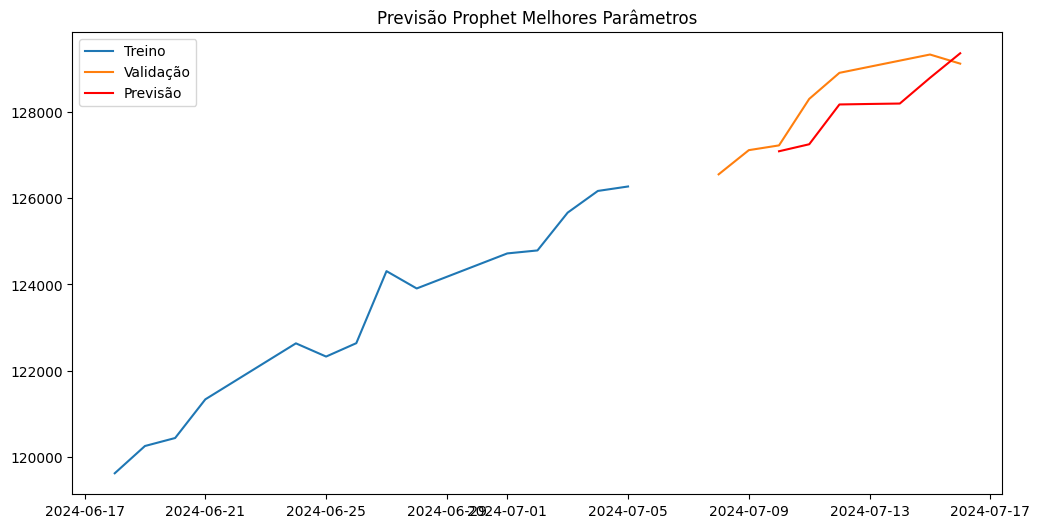

In [392]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(last_14_train['ds'], last_14_train['y'], label='Treino')
plt.plot(val_df_prophet['ds'], val_df_prophet['y'], label='Validação')
plt.plot(forecast_val.index, forecast_val['yhat'], label='Previsão', color='red')
plt.legend()
plt.title('Previsão Prophet Melhores Parâmetros')
plt.show()

## Comparando os resultados dos modelo Prophet:


In [393]:
df_resultado_prophet = pd.DataFrame(
    [erros_prophet,erros_prophet_best_param],
    columns=['MAE','MSE','MAPE'],
    index=["Prophet","Prophet - Melhores Parâmetros"]
)
df_resultado_prophet

,MAE,MSE,MAPE
Prophet,589.669785,432613.115736,0.457979
Prophet - Melhores Parâmetros,338.571429,166094.571429,0.263585


### Conclusão

Com a utilização do algoritmo 'Randomized Search com Validação Cruzada', conseguimos aprimorar os resultados do modelo Prophet, diminuindo o Erro Percentual Absoluto Médio (MAPE) de aproximadamente 0.46% para 0.26%.

Concluímos que o Prophet aprimorado obteve a melhor acurácia, sugerimos assim que os senhores utilizem esse modelo para prever os próximos dias do Ibovespa.

Como evoluções para o futuro, poderemos utilizar técnicas de redes neurais para prever com maior precisão.